# 4.0 Modeling

## 4.1 ARIMA (Autoregressive integrated moving average)

An ARIMA model describes a univariate time series as a combination of autoregressive (AR) and moving average (MA) lags which capture the autocorrelation within the time series. The order of integration denotes how many times the series has been differenced to obtain a stationary series.

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

We write an ARIMA(p,d,q) model for some time series data y_t, where p is the number of autoregressive lags, d is the degree of differencing and q is the number of moving average lags.

![alt text](pic3.png)
![alt text](pic4.png)


## 4.2 SARIMA

A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA models we have seen so far. It is written as follows:

![alt text](pic6.png)

Where m = number of observations per year. We use uppercase notation for the seasonal parts of the model, and lowercase notation for the non-seasonal parts of the model. The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period.


## 4.3 LightGBM

- Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm
- It splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. 
- Leaf wise splits lead to increase in complexity and may lead to overfitting but it can be overcome by specifying another parameter max-depth which specifies the depth to which splitting will occur.
- LightGBM uses a novel technique of Gradient-based One-Side Sampling (GOSS) which downsamples the instances on the basis of gradients to filter out the data instances for finding a split GOSS.

![alt text](pic5.png)

## 4.4 Long Short Term Memory (LSTM)

Long Short Term Memory networks are a special kind of RNN, capable of learning long-term dependencies. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior.

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

![alt text](pic7.png)

## 4.5 Neural Prophet


NeuralProphet is an upgraded version of Prophet that is built using PyTorch and uses deep learning models such as AR-Net for time-series forecasting. The main benefit of using NeuralProphet is that it features a simple API inspired by Prophet, but gives you access to more sophisticated deep learning models for time-series forecasting.

![alt text](pic8.png)

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import random
from itertools import cycle, islice
import statsmodels.api as sm
from pylab import rcParams

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from matplotlib.ticker import MaxNLocator

from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
calendar = pd.read_csv("calendar.csv")
sell_df = pd.read_csv("sell_prices.csv")
train_val_df = pd.read_csv("sales_train_validation.csv")
train_eval_df = pd.read_csv("sales_train_evaluation.csv")
sub_df = pd.read_csv("sample_submission.csv")

In [106]:
#unit sales for different products
data = pd.DataFrame(np.array(train_val_df.iloc[:,6:]).astype(float))

In [92]:
#Adfuller test on one of the product
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data.iloc[100,:], autolag='AIC' )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.983672
p-value: 0.000000


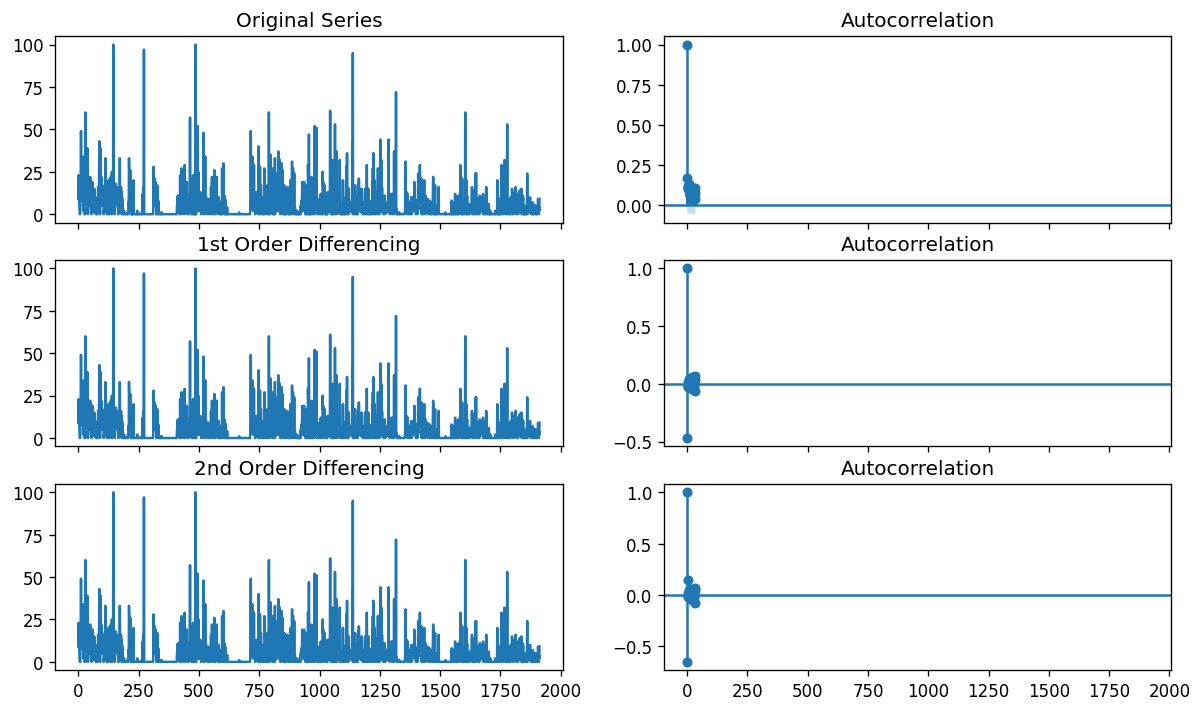

In [109]:
import numpy as np, pandas as pd
from numpy import sqrt,mean,log,diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(12,7), 'figure.dpi':120})

product1 = data.iloc[15000,:]
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(product1); axes[0, 0].set_title('Original Series')
plot_acf((product1), ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(product1); axes[1, 0].set_title('1st Order Differencing')
plot_acf(product1.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(product1); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(product1.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

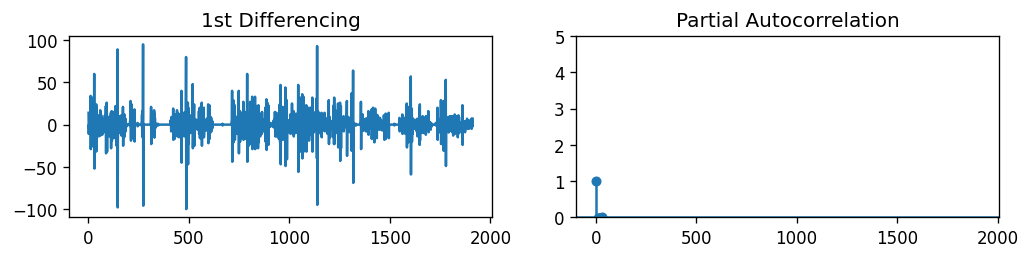

In [113]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(10,2), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(product1.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(product1.diff().dropna(), ax=axes[1])

plt.show()

In [147]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model

def arima_model(prod_num, order):
    train = np.array(data.iloc[prod_num,:])
    #test = prod1.value[1850:-1]
    model = ARIMA(train, order= order)
    model_fit = model.fit(disp=-2)
    print(model_fit.summary())

    # Forecast
    fc, se, conf = model_fit.forecast(28, alpha=0.01)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc,index= range(1913,1941,1))
    lower_series = pd.Series(conf[:, 0], index= range(1913,1941,1))
    upper_series = pd.Series(conf[:, 1], index= range(1913,1941,1))

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(pd.DataFrame(train)[1800:], label='training')
    #     plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1913
Model:                     ARMA(2, 1)   Log Likelihood               -6592.444
Method:                       css-mle   S.D. of innovations              7.587
Date:                Wed, 23 Jun 2021   AIC                          13194.889
Time:                        19:37:02   BIC                          13222.671
Sample:                             0   HQIC                         13205.113
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2677      8.024      1.653      0.098      -2.460      28.995
ar.L1.y        1.1490      0.023     50.228      0.000       1.104       1.194
ar.L2.y       -0.1497      0.023     -6.563      0.0

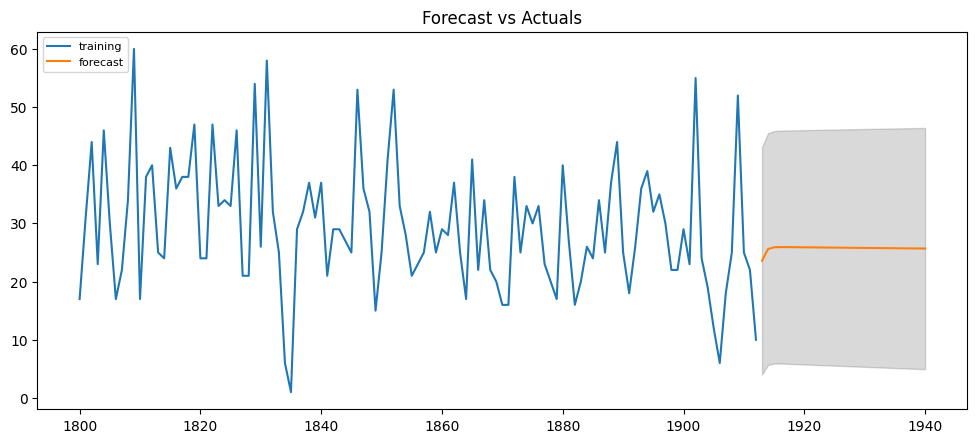

In [145]:
arima_model(20000, (2,0,1))

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1912
Model:                 ARIMA(7, 1, 3)   Log Likelihood               -1203.549
Method:                       css-mle   S.D. of innovations              0.454
Date:                Wed, 23 Jun 2021   AIC                           2431.098
Time:                        19:38:51   BIC                           2497.769
Sample:                             1   HQIC                          2455.634
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.003      0.174      0.862      -0.004       0.005
ar.L1.D.y      0.9018      0.201      4.479      0.000       0.507       1.296
ar.L2.D.y      0.3386      0.233      1.453      0.1

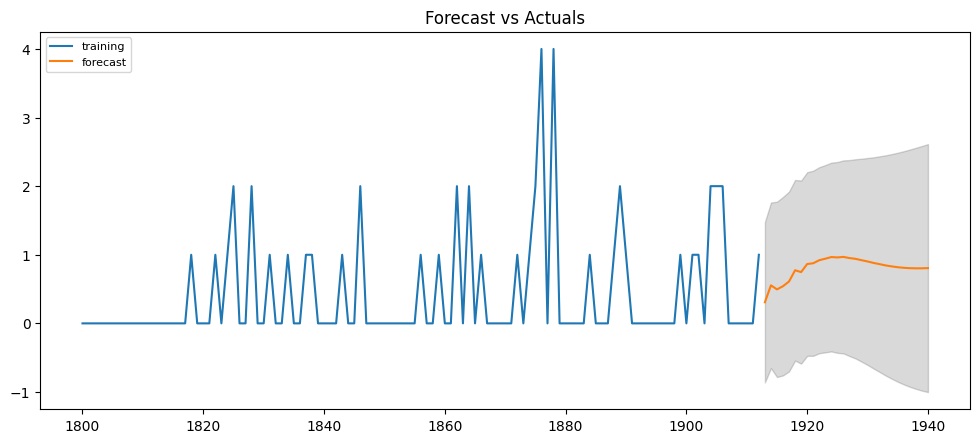

In [148]:
arima_model(30000, (7,1,3))

In [30]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': inf,
 'me': 1.1152603660851121,
 'mae': 1.4736992243479377,
 'mpe': inf,
 'rmse': 1.8482944503920793,
 'acf1': -0.03774566074942515,
 'corr': 0.03401787866360418,
 'minmax': 0.35459537965774723}

In [153]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

def autoarima(prod_num):
    train = np.array(data.iloc[prod_num,:])
    smodel = pm.auto_arima(train,start_p=1, start_q=1,
                             test='adf',
                             max_p=8, max_q=8, m=12,
                             start_P=0, seasonal=True,
                             d=None, D=0, trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

    print(smodel.summary())
    # Forecast

    n_periods = 28
    fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)

    # make series for plotting purpose 
    fitted_series = pd.Series(fitted, index= range(1913,1941,1))
    lower_series = pd.Series(confint[:, 0],index=range(1913, 1941,1))
    upper_series = pd.Series(confint[:, 1],index=range(1913, 1941,1))

    # Plot
    plt.plot(pd.DataFrame(train)[1800:])
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=3108.727, Time=6.07 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3152.986, Time=0.23 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3147.617, Time=0.88 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3148.433, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3488.403, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=3101.891, Time=1.67 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=3107.589, Time=5.24 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=7.11 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3147.770, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3147.043, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=3111.877, Time=1.87 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=3107.833, Time=2.00 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=3145.185, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=3143.929, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[12]

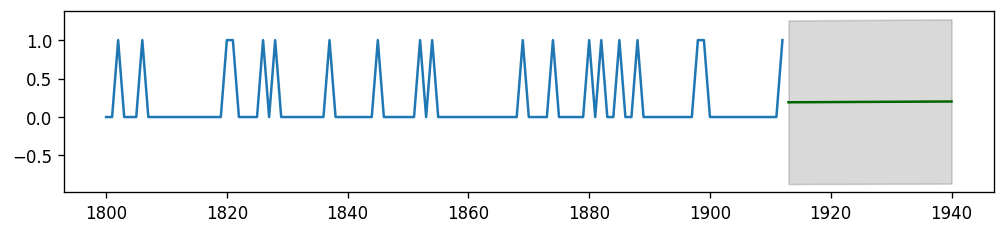

In [154]:
autoarima(1200)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=3490.824, Time=3.22 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3859.395, Time=0.18 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3711.559, Time=0.80 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3737.400, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4127.731, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=3488.908, Time=0.84 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=3490.836, Time=5.38 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=9.77 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3774.461, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3738.491, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=3490.410, Time=2.46 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=3490.450, Time=2.35 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=3711.933, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=3653.462, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[12]

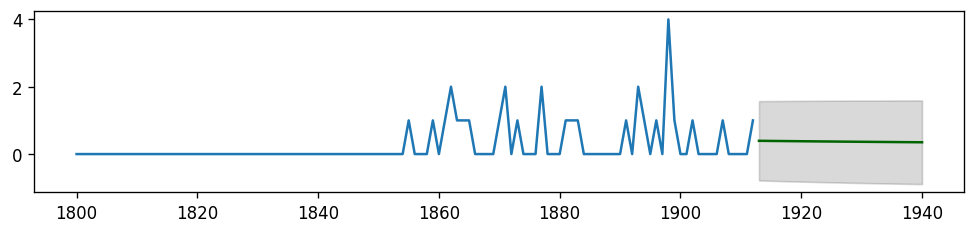

In [155]:
autoarima(1500)

In [159]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

def autoarima(prod_num):
    train = np.array(data.iloc[prod_num,:])
    smodel = pm.auto_arima(train,start_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=None, D=1, trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

    print(smodel.summary())
    # Forecast

    n_periods = 28
    fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)

    # make series for plotting purpose 
    fitted_series = pd.Series(fitted, index= range(1913,1941,1))
    lower_series = pd.Series(confint[:, 0],index=range(1913, 1941,1))
    upper_series = pd.Series(confint[:, 1],index=range(1913, 1941,1))

    # Plot
    plt.plot(pd.DataFrame(train)[1800:])
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=26.95 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=8850.552, Time=0.27 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8369.057, Time=2.93 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=7.88 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=8848.554, Time=0.21 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=8818.812, Time=1.19 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=8120.880, Time=12.43 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=71.58 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=17.18 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=8196.077, Time=14.68 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=8115.306, Time=21.22 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=8370.172, Time=5.28 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=77.59 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=23.88 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AI

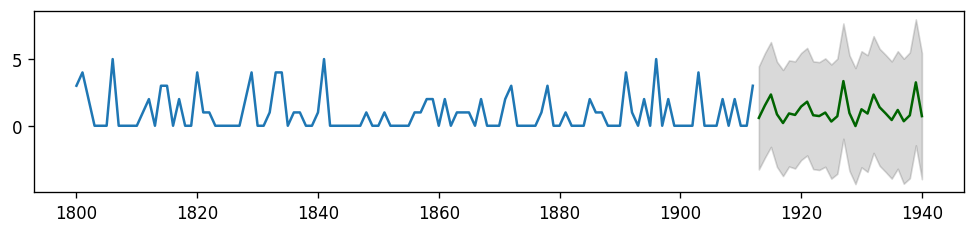

In [160]:
autoarima(2000)

In [94]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

smodel = pm.auto_arima(train,start_p=1, start_q=1,
                         test='adf',
                         max_p=8, max_q=8, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True)

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=12.84 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5097.075, Time=0.52 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4562.865, Time=2.38 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5095.077, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5099.016, Time=0.38 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4380.598, Time=8.64 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=33.58 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.09 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4380.371, Time=7.11 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=4561.817, Time=1.90 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=20.12 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.35 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=4380.419, Time=8.63 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=437

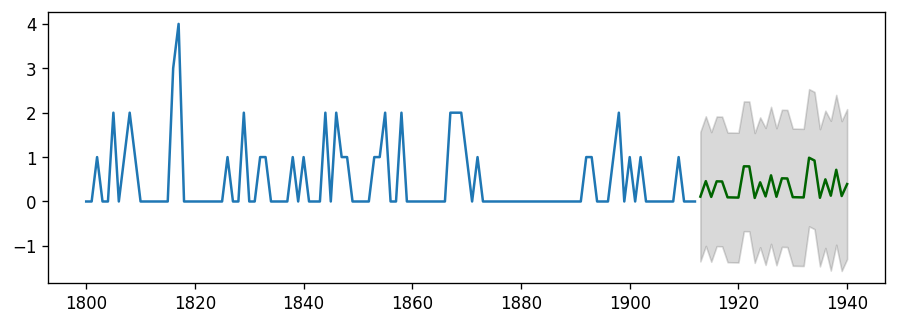

In [98]:
# Forecast

# Forecast

n_periods = 28
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)

# make series for plotting purpose 
fitted_series = pd.Series(fitted, )
lower_series = pd.Series(confint[:, 0],index=range(1913, 1941,1))
upper_series = pd.Series(confint[:, 1],index=range(1913, 1941,1))

# Plot
plt.plot(train[1800:])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.show()

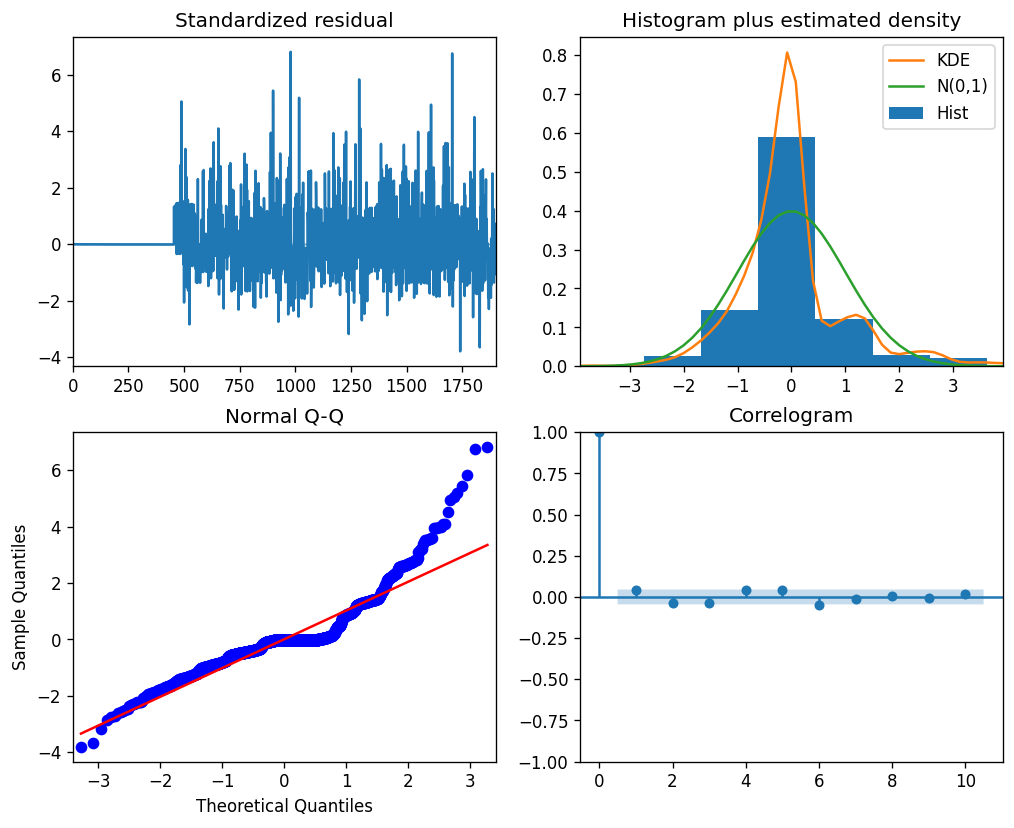

In [99]:
smodel.plot_diagnostics(figsize=(10,8))
plt.show()

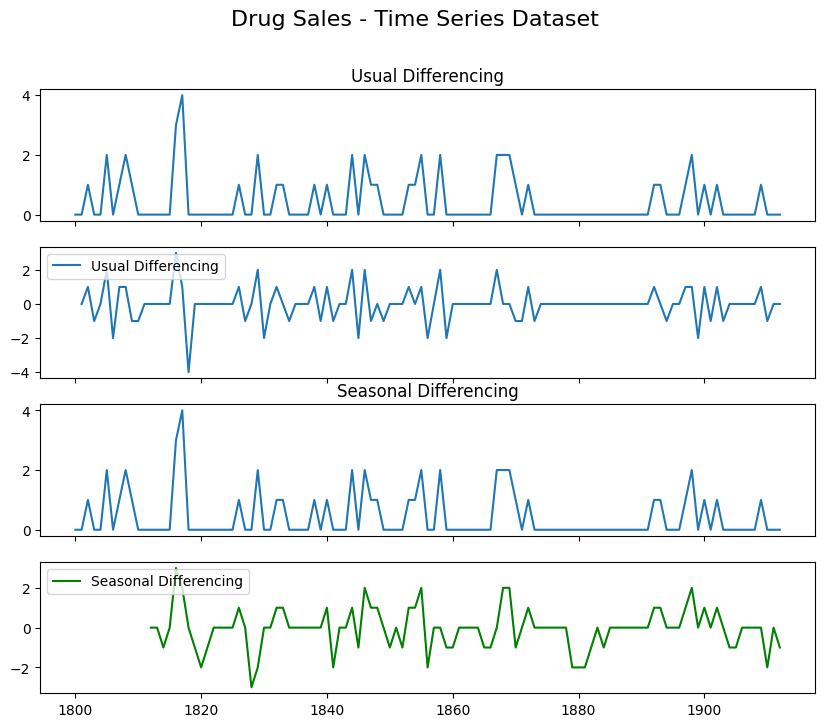

In [105]:
# Plot
fig, axes = plt.subplots(4, 1, figsize=(10,8), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(train[1800:], label='Original Series')
axes[1].plot(train[1800:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[1].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[2].plot(train[1800:], label='Original Series')
axes[3].plot(train[1800:].diff(12), label='Seasonal Differencing', color='green')
axes[2].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Sales - Time Series Dataset', fontsize=16)
plt.show()